In [1]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import neuro_morpho_toolbox as nmt

%matplotlib inline

/home/penglab/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.98
Loading CCF brain structure data...
Loading time: 0.01


In [2]:
space = nmt.annotation.space

swc_path = "/Users/pengxie/Documents/Research/CLA/data/CCF/mapped/swc/Whole/prune/"

In [3]:
# LUT of selected regions
LUT = {0:0}

for i in nmt.bs.level.index.tolist():
    LUT[i] = 0
for target_region in nmt.bs.selected_regions:
    for i in nmt.bs.get_all_child_id(target_region):
        LUT[i] = target_region
    

def node_to_region(x,y,z,space=space):
    x = np.int(x/space['x'])
    y = np.int(y/space['x'])
    z = np.int(z/space['x'])
    return nmt.annotation.array[x,y,z]

def get_children(swc):
    parents = swc.parent.tolist()
    names = swc.index.tolist()
    
    children = [[] for i in range(len(swc))]
    for i,j in enumerate(parents):
        if j == (-1):
            continue
        children[names.index(j)].append(i)
    return children
        
    
def get_node_regions(swc):
    
    parents = swc.parent.tolist()
    assert parents.count(-1) == 1, "Number of roots != 1"
    root = parents.index(-1)
    names = swc.index.tolist()    
    children = get_children(swc)
    
    # DFS
    # Initialization
    stack = [root]
    visited = [0]*len(swc)
    visited[0] = 1
    res = {}
    
    
    # Begin DFS
    while len(stack)>0:
        cur_node = stack[-1]
        whether_push = 0
        for i in children[cur_node]:  
            if visited[i] == 0:
                visited[i] = 1
                stack.append(i)
                whether_push = 1
                break
        if whether_push == 0:
            tp = stack.pop()
            x,y,z = swc.iloc[tp, 1:4].tolist()
            if LUT[node_to_region(x,y,z)] != 0:
                res[tp] = nmt.bs.level.loc[LUT[node_to_region(x,y,z)], "Abbrevation"]
            else:
                res[tp] = "unknown"
#                 print(tp, nmt.bs.level.loc[LUT[node_to_region(x,y,z)], "Abbrevation"])  
    return res


In [4]:
# Alignment of non-branching neurites

# 1. Trace-back from tips
def get_tips(swc):
    children = get_children(swc)
    tips = []
    for i,cur_children in enumerate(children):
        if len(cur_children)==0:
            tips.append(i)
    return tips

def get_path(swc, end_node, region_dict=None, downsample=1):
    # Get a projection path by back-tracing: from specified end_node to soma
    assert end_node in range(len(swc)), "end_node out of bound"
    parents = swc.parent.tolist()
    assert parents.count(-1) == 1, "Number of roots != 1"
    root = parents.index(-1)
    names = swc.index.tolist()    
    if region_dict is None:
        region_dict = get_node_regions(swc)

    path = []
    cur_node = end_node
    ct = 0
    while cur_node != root:
        if (ct % downsample)==0:
            path.insert(0, region_dict[cur_node])
        ct = ct + 1
        cur_node = names.index(parents[cur_node])
    path.insert(0, region_dict[root])
    return path 

In [5]:
match_score = 2
mismatch_penalty = -1
gap_penalty = -1

def path_alignment(p1, p2):
    # 1. Construct tables for score and shifts
    mscore = np.zeros((len(p1)+1, len(p2)+1))
    shift_left = np.zeros((len(p1)+1, len(p2)+1), dtype='int16')
    shift_up = np.zeros((len(p1)+1, len(p2)+1), dtype='int16')
    shift_type = np.zeros((len(p1)+1, len(p2)+1), dtype='int16') - 1
    
    # 2. Fill the tables
    # 2.1 initialization:
    for i in range(1, mscore.shape[0]):
        mscore[i, 0] = -i
        shift_up[i, 0] = 1
        shift_type[i, 0] = 2
    for j in range(1, mscore.shape[1]):
        mscore[0, j] = -j
        shift_left[0, j] = 1
        shift_type[0, j] = 0
    # 2.2 Fill the rest of the tables
    for i in range(1, mscore.shape[0]):
        for j in range(1, mscore.shape[1]):
            s0 = mscore[i, j-1] + gap_penalty
            if p1[i-1] != p2[j-1]:
                s1 = mscore[i-1,j-1] + mismatch_penalty
            else:
                s1 = mscore[i-1,j-1] + match_score
            s2 = mscore[i-1, j] + gap_penalty
            mscore[i,j] = max([s0,s1,s2])
            cur_type = np.argmax([s0,s1,s2])
            shift_type[i, j] = cur_type
            if cur_type == 0:
                shift_left[i,j] = 1
                shift_up[i,j] = 0
                continue
            if cur_type == 1:
                shift_left[i,j] = 1
                shift_up[i,j] = 1
                continue
            if cur_type == 2:
                shift_left[i,j] = 0
                shift_up[i,j] = 1
                continue
                
    # 3. Traceback
    seq_1 = []
    seq_2 = []
    i = mscore.shape[0]-1
    j = mscore.shape[1]-1
    while ((i!=0) | (j!=0)):
        if shift_up[i,j] == 1:
            seq_1.insert(0, p1[i-1])
        else:
            seq_1.insert(0, '-')
        if shift_left[i,j] == 1:
            seq_2.insert(0, p2[j-1])
        else:
            seq_2.insert(0, '-')            
        i,j = [i - shift_up[i,j], j - shift_left[i,j]]
    
    return mscore, seq_1, seq_2


# branches: 1
path length: 22
# branches: 3
path length: 17
path length: 18
path length: 23
Global alignment score: 6

Path_1	-	Path_2
ORBl	-	ORBl
ORBl	-	ORBl
AId	 	ORBl
AId	 	ORBl
AId	 	ORBl
AId	 	CP
fiber	 	CP
fiber	-	fiber
ACAv	-	ACAv
unkno	 	-
ACAv	-	ACAv
fiber	 	PL
fiber	-	fiber
ORBl	 	MOs
ORBl	 	MOs
ORBl	-	ORBl
ORBl	 	MOs
ORBl	-	ORBl
ORBl	-	ORBl
ORBl	-	ORBl
ORBl	 	FRP
ORBl	 	MOs
-	 	MOs
-	 	unkno


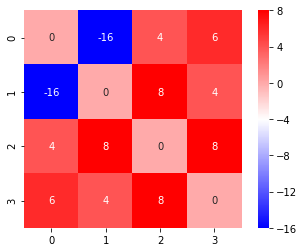

In [6]:


# Testing data
# 'res' is a dict line_number -> region

name_1 = "17109_01701_01800_X8048_Y22277_QCed.swc"
name_2 = "17109_1801_1900_X6698_Y12550_QCed.swc"

neuron_1 = nmt.swc(swc_path + name_1)
neuron_2 = nmt.swc(swc_path + name_2)

region_dict_1 = get_node_regions(neuron_1.swc)
region_dict_2 = get_node_regions(neuron_2.swc)

paths = []
for cur_swc, cur_region_dict in zip([neuron_1.swc, neuron_2.swc], [region_dict_1, region_dict_2]):
    print("# branches: %d" % len(get_tips(cur_swc)))
    for cur_tip in get_tips(cur_swc):
        tp = get_path(cur_swc, cur_tip, cur_region_dict, downsample=5)
        paths.append(tp)
        print("path length: %d" % len(paths[-1]))

mscore, seq_1, seq_2 = path_alignment(paths[0], paths[3])
# res = path_alignment('TCG', 'AATCG')
plt.imshow(mscore, cmap='bwr')
assert len(seq_1)==len(seq_2)
print("Global alignment score: %d\n" % mscore[mscore.shape[0]-1, mscore.shape[1]-1])
print("%s\t-\t%s" % ("Path_1", "Path_2"))
for i in range(len(seq_1)):
    if seq_1[i][:5] == seq_2[i][:5]:
        sep = '-'
    else:
        sep = ' '
    print("%s\t%s\t%s" % (seq_1[i][:5], sep, seq_2[i][:5]))
    
m = len(paths)
pair_scores = np.zeros((m,m))
for i in range(0,m):
    for j in range(i+1, m):
        mscore, _, _ = path_alignment(paths[i], paths[j])
        pair_scores[i,j] = mscore[mscore.shape[0]-1, mscore.shape[1]-1]
        pair_scores[j,i] = pair_scores[i,j]
        
sns.heatmap(pair_scores, cmap='bwr', annot=True)

# Apply to CLA dataset

In [46]:
def standardize_cellid(cell_name):
    '''
    The name of a cell is of the format:
        "zstart_zend_x_y"
        or
        "z_x_y"
    '''
    tp = cell_name.replace("-", "_").replace("x", "X").replace("y","Y")
    tp = tp.split("_")
    n_fields = 0
    for i,j in enumerate(tp):
        if j.startswith("X"):
            n_fields = i+2
            break
    if n_fields == 0:
        print(cell_name)
        return
    tp = cell_name.replace("-", "_").replace("X", "").replace("x", "").replace("Y", "").replace("y","")
    tp = tp.split("_")[:n_fields]
    for i, value in enumerate(tp):
        if(len(value)>5):
            print("Name format error of 'standardize_cellid' ", cell_name)
        value = (["0"]*(5-len(value))) + [value]
        value = "".join(value)
        tp[i] = value
    if(len(tp)>4):
        print("Name format error of 'standardize_cellid' ", cell_name)
    tp = [tp[0]] * (4 - len(tp)) + tp
#     print(tp)
    res = tp[0]+"_"+tp[1]+"_X"+tp[2]+"_Y"+tp[3]
    return res

def standardize_cellid_list(cell_list):
    res = []
    for i, j in enumerate(cell_list):
        tp = j.replace("-", "_").replace(" ", "_").replace("_Finalized", "").replace("_QCed", "").replace(".swc", "").replace(".eswc", "").replace(".ano", "")
        brain_id = j.split("_")[0]
        cell_id = "_".join(tp.split("_")[1:])
        cell_id = standardize_cellid(cell_id)
        res.append("_".join((brain_id, cell_id)))
    return res

In [48]:
paths_dict = {}
swc_list = [f for f in listdir(swc_path) if f.endswith("swc")][:100]
swc_list_standard = standardize_cellid_list(swc_list)
for cur_file, cur_name in zip(swc_list, swc_list_standard):
    cur_swc = nmt.swc(swc_path + cur_file).swc
    cur_region_dict = get_node_regions(cur_swc)
    cur_paths = []
    for cur_tip in get_tips(cur_swc):
        cur_paths.append(get_path(cur_swc, cur_tip, cur_region_dict, downsample=5))
    paths_dict[cur_name] = cur_paths
    
n_neurons = len(paths_dict)

In [50]:
def pairwise_similarity(paths1, paths2):
    res = -1e20
    for p1 in paths1:
        for p2 in paths2:
            mscore, seq_1, seq_2 = path_alignment(p1, p2)
            cur_score = mscore[len(p1), len(p2)]
            if res < cur_score:
                res = cur_score
    return res

# Testing
print("%s \n%s" % (swc_list_standard[0], swc_list_standard[1]))
pairwise_similarity(paths_dict[swc_list_standard[0]], paths_dict[swc_list_standard[1]])

17781_05655_05655_X10641_Y11102 
236174_05338_05437_X13590_Y07348


-17.0

In [60]:
celltypes = pd.read_csv("/Users/pengxie/Documents/Research/CLA/data/CCF/CellTypes.csv", dtype="str")
celltypes = celltypes.drop_duplicates()
for i in range(len(celltypes)):
    cell_id = str(celltypes.iloc[i,1]).strip().replace("-", "_").replace(" ", "_").replace("_Finalized", "").replace("_QCed", "").replace(".ano", "")
    celltypes.iloc[i,1] = standardize_cellid(cell_id)
celltypes.index = [str(celltypes.iloc[i,0]) + "_" + str(celltypes.iloc[i,1]) for i in range(len(celltypes))]
celltypes["Subtype"] = pd.Categorical(celltypes.Cell_type)
celltypes["Cell_type"] = pd.Categorical([celltypes.Cell_type[i].split("_")[0] for i in range(len(celltypes))])
celltypes.head()

,Brain_name,Cell_name,Cell_type,Subtype
17781_03668_03668_X17825_Y13313,17781,03668_03668_X17825_Y13313,CLA,CLA_Ia
17781_04095_04095_X17570_Y12460,17781,04095_04095_X17570_Y12460,CLA,CLA_Ia
17781_03320_03320_X16423_Y14748,17781,03320_03320_X16423_Y14748,CLA,CLA_Ia
236174_03215_03215_X11999_Y11133,236174,03215_03215_X11999_Y11133,CLA,CLA_Ia
236174_03229_03328_X12413_Y11831,236174,03229_03328_X12413_Y11831,CLA,CLA_Ia


In [106]:
similarity_array = np.zeros((n_neurons, n_neurons))
for i in range(len(paths_dict)):
    for j in range(i+1, len(paths_dict)):
        similarity_array[i, j] = pairwise_similarity(paths_dict[swc_list_standard[i]], 
                                                     paths_dict[swc_list_standard[j]])
        similarity_array[j, i] = similarity_array[i, j]

In [107]:
# Get rid of outliers
cell_list = []
for i,j in enumerate(swc_list_standard):
    if np.sort(similarity_array[i,:])[-2]>5:
        cell_list.append(j)
    else:
        print(j)

236174_05338_05437_X13590_Y07348
17109_06401_06500_X07641_Y03978
17781_05166_05166_X11993_Y10858
17781_04874_04874_X11466_Y11924
17781_06866_06866_X08954_Y41812
236174_07077_07089_X14579_Y30892
17781_03668_03668_X09453_Y17266
17781_03139_03139_X20033_Y17506
17781_04698_04698_X17857_Y11456
236174_03893_03908_X17507_Y26071
17781_06228_06228_X12697_Y08412
17781_05894_05894_X11460_Y10079


In [108]:
similarity_df = pd.DataFrame(similarity_array, index=swc_list_standard, columns=swc_list_standard)
similarity_df = similarity_df.loc[cell_list]
similarity_df = similarity_df[cell_list]

In [80]:
celltype_color_dict = {"CLA":"C0", "pc":"C1"}
u_subtype = sorted(list(set(celltypes.Subtype.tolist())))
subtype_color_dict = dict(zip(u_subtype, ["C"+str(i) for i in range(len(u_subtype))]))

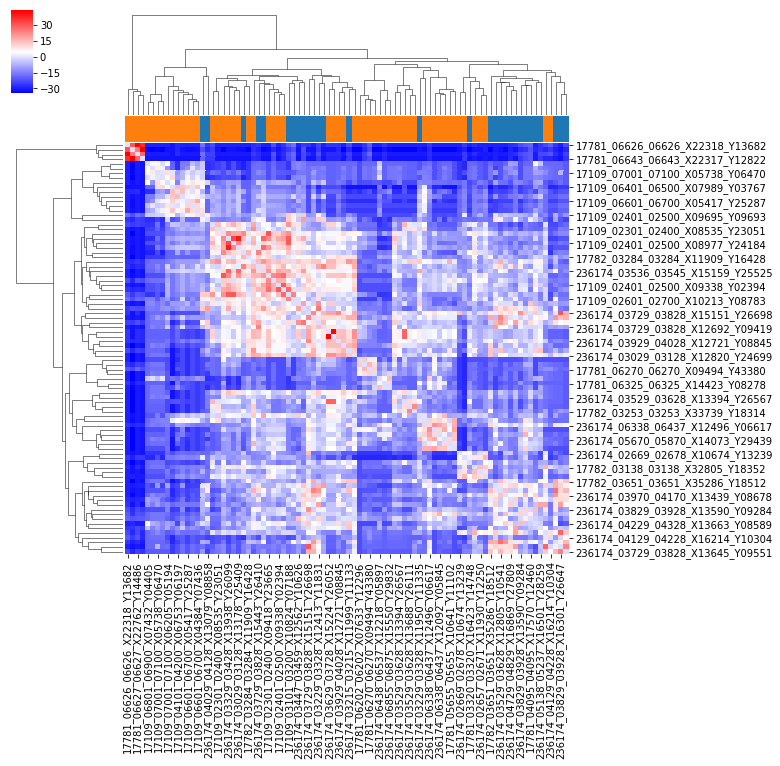

In [109]:
_ = sns.clustermap(similarity_df, 
                   col_colors=[celltype_color_dict[celltypes.loc[i, "Cell_type"]] for i in similarity_df.index.tolist()],
                   cmap='bwr', annot=False)

In [116]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

kmeans = KMeans(n_clusters=8, random_state=0).fit(similarity_df)

Z = TSNE(n_components=2, perplexity=8).fit_transform(similarity_df)

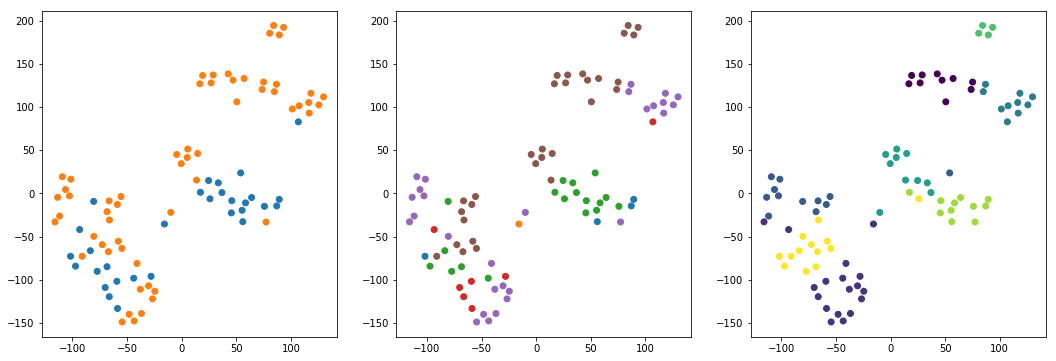

In [117]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[1].scatter(Z[:,0], Z[:,1], 
            c=[subtype_color_dict[celltypes.loc[i, "Subtype"]] for i in similarity_df.index.tolist()]
           )
ax[0].scatter(Z[:,0], Z[:,1], 
            c=[celltype_color_dict[celltypes.loc[i, "Cell_type"]] for i in similarity_df.index.tolist()]
           )
ax[2].scatter(Z[:,0], Z[:,1], c=kmeans.labels_)

In [120]:
swc_dict = dict(zip(swc_list_standard, swc_list))

In [128]:
import shutil
for cluster_id in range(8):
    if os.path.isdir(swc_path+str(cluster_id)):
        shutil.rmtree(swc_path+str(cluster_id))
    os.mkdir(swc_path+str(cluster_id))
    for i,j in enumerate(cell_list):
        if kmeans.labels_[i] == cluster_id:
            shutil.copy(swc_path + swc_dict[j], swc_path+str(cluster_id)+"/"+swc_dict[j])

In [124]:
os.path.isdir(swc_path)

True

In [126]:
shutil.rmtree(swc_path+str(cluster_id))